In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set()

In [ ]:
df = pd.read_csv('final_data.csv')

<Axes: xlabel='Year'>

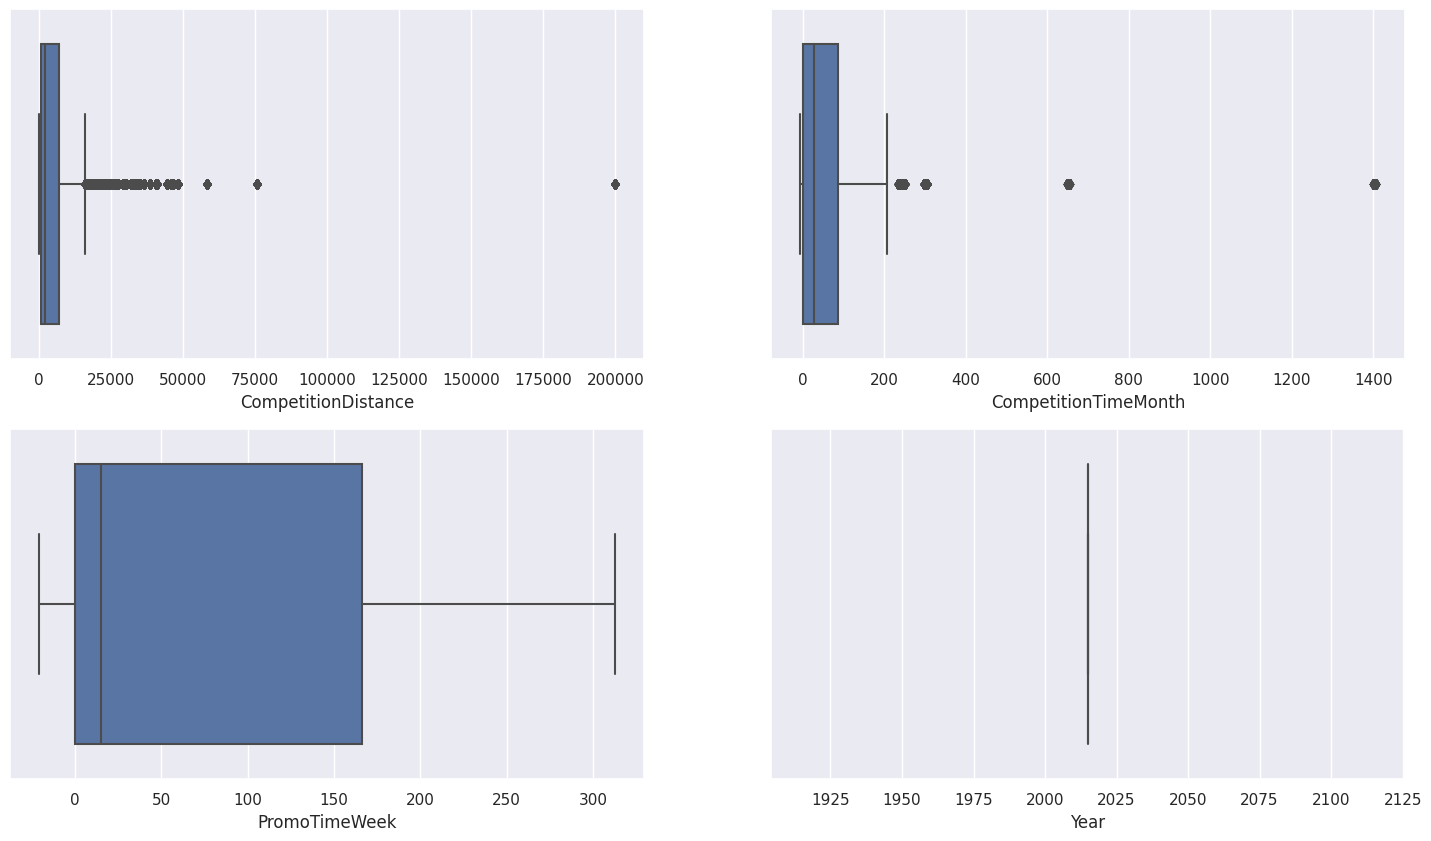

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

sns.boxplot(ax=axes[0,0], data=df, x='CompetitionDistance')
sns.boxplot(ax=axes[0,1], data=df, x='CompetitionTimeMonth')
sns.boxplot(ax=axes[1,0], data=df, x='PromoTimeWeek')
sns.boxplot(ax=axes[1,1], data=df, x='Year')

Vamos usar o RobustScaler para as variáveis CompetitionDistance e CompetitionTimeMonth devido seus outliers.


Vamos usar o Minmax para o PromoTimeWeek e Year devido a estas duas variáveis não terem outliers relevantes.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

### Aplicando Scaler

In [ ]:
rs = RobustScaler()
minmax = MinMaxScaler()

In [ ]:
df['CompetitionDistance'] = rs.fit_transform(df[['CompetitionDistance']].values)

In [ ]:
pickle.dump( rs, open( './competition_distance_scaler.pkl', 'wb') )

In [ ]:
df['CompetitionTimeMonth'] = rs.fit_transform(df[['CompetitionTimeMonth']].values)

In [ ]:
pickle.dump( rs, open( './competition_time_month_scaler.pkl', 'wb') )

In [ ]:
df['PromoTimeWeek'] = minmax.fit_transform(df[['PromoTimeWeek']].values)

In [ ]:
pickle.dump( minmax, open( './promo_time_week_scaler.pkl', 'wb') )

In [ ]:
df['Year'] = minmax.fit_transform(df[['Year']].values)

In [ ]:
pickle.dump( minmax, open( './year_scaler.pkl', 'wb') )

### Encoding

In [ ]:
# StateHoliday - One Hot Encoding
df = pd.get_dummies( df, prefix=['StateHoliday'], columns=['StateHoliday'] )

# StoreType - Label Encoding
le = LabelEncoder()
df['StoreType'] = le.fit_transform( df['StoreType'] )
pickle.dump( le, open( './store_type_scaler.pkl', 'wb') )

# Assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df['Assortment'] = df['Assortment'].map( assortment_dict )

In [ ]:
df.head()

,Store,DayOfWeek,Date,Sales,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,WeekOfYear,YearWeek,CompetitionSince,CompetitionTimeMonth,PromoSince,PromoTimeWeek,StateHoliday_Christmas,StateHoliday_EasterHoliday,StateHoliday_PublicHoliday,StateHoliday_RegularDay
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [ ]:
# Transformação de grandeza para a variável resposta Sales
df['Sales'] = np.log1p(df['Sales'])

Transformação de natureza cíclica

In [ ]:
# day of week
df['DayOfWeekSin'] = df['DayOfWeek'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df['day_of_week_cos'] = df['DayOfWeek'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
# month
df['month_sin'] = df['Month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df['month_cos'] = df['Month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
# day
df['day_sin'] = df['Day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df['day_cos'] = df['Day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
# week of year
df['week_of_year_sin'] = df['WeekOfYear'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df['week_of_year_cos'] = df['WeekOfYear'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ))

### Seleção das variáveis

Para a seleção das variáveis será utilizado o método de seleção por subset, por meio do algoritmo Boruta

In [ ]:
# deletando as variáveis que já foram derivadas
cols_drop = ['WeekOfYear', 'Day', 'Month', 'DayOfWeek', 'PromoSince',
             'CompetitionSince', 'YearWeek' ]
df2 = df.drop( cols_drop, axis=1 )

Separando em dados de treine e teste

In [ ]:
# training dataset
X_train = df2[df2['Date'] < '2015-06-19']
y_train = X_train['Sales']
# test dataset
X_test = df2[df2['Date'] >= '2015-06-19']
y_test = X_test['Sales']
print( 'Training Min Date: {}'.format( X_train['Date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['Date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['Date'].min() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00


Implementando o boruta

In [ ]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_jobs=-1)

In [ ]:
# dados de treino e teste para o boruta
X_train_n = X_train.drop(['Date','Sales'], axis=1).values
y_train_n = y_train.values.ravel()

In [ ]:
boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


In [ ]:
X_train_fs = X_train.drop( ['Date', 'Sales'], axis=1 )

In [ ]:
cols_selected = boruta.support_.tolist()
cols_selected

[True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True]

In [ ]:
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['Store',
 'Promo',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'CompetitionTimeMonth',
 'PromoTimeWeek',
 'DayOfWeekSin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [ ]:
cols_not_selected = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)
cols_not_selected

array(['IsPromo', 'SchoolHoliday', 'StateHoliday_Christmas',
       'StateHoliday_EasterHoliday', 'StateHoliday_PublicHoliday',
       'StateHoliday_RegularDay', 'Year', 'month_sin', 'week_of_year_sin'],
      dtype=object)

Agora precisamos ver se as variáveis que o boruta considerou como sem importância estão de acordo com a importância das variáveis que utilizamos na validação das hipóteses durante a análise exploratória de dados.

As hipóteses com maiores relevâncias foram H9, H10, H11 e H12.

A H9 dizia que as lojas deveriam vender mais ao longo dos anos, e tal hipótese foi definida como alta relevância, enquanto o boruta colocou Year como não importante
- Manteremos o ano/`Year` de fora

A H10 avaliava as vendas de acordo com o mês, e o boruta a colocou apenas o `month_cos` como relevante
- Manteremos o `month_cos` e `month_sin`

A H11 considerava o dia relevante, e o boruta também o considerou

A H12 considerava os finais de semana `DayOfWeek`, e boruta também os considerou: `day_of_week_sin` e `day_of_week_cos`. Além disso, também iremos acrescentar `week_of_year_sin`



Agora precisamos apenas selecionar as variávies relevantes

In [ ]:
cols_selected_boruta = [
 'Store',
 'Promo',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'CompetitionTimeMonth',
 'PromoTimeWeek',
 'DayOfWeekSin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

Adicionando as variávies que tinham sido removidas para o treinamento do boruta

In [ ]:
feat_remains = ['Date','Sales']

In [ ]:
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_remains)
cols_selected_boruta_full

['Store',
 'Promo',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'CompetitionTimeMonth',
 'PromoTimeWeek',
 'DayOfWeekSin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'Date',
 'Sales']

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import datetime
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

In [ ]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta]

### Average model

Criando um modelo de média

In [ ]:
def ml_error( model_name, y, yhat ):
  mae = mean_absolute_error( y, yhat )
  mape = mean_absolute_percentage_error( y, yhat )
  rmse = np.sqrt( mean_squared_error( y, yhat ) )
  return pd.DataFrame( { 'Model Name': model_name,
  'MAE': mae,
  'MAPE': mape,
  'RMSE': rmse }, index=[0] )

In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
  mae_list = []
  mape_list = []
  rmse_list = []
  for k in reversed( range( 1, kfold+1 ) ):
      if verbose:
        print( '\nKFold Number: {}'.format( k ) )
      # start and end date for validation
      validation_start_date = x_training['Date'].max() - datetime.timedelta(days=k*6*7)
      validation_end_date = x_training['Date'].max() - datetime.timedelta(days=(k-1)*6*7)
      # filtering dataset
      training = x_training[x_training['Date'] < validation_start_date]
      validation = x_training[(x_training['Date'] >= validation_start_date) &
      (x_training['Date'] <= validation_end_date)]
      # training and validation dataset
      # training
      xtraining = training.drop( ['Date', 'Sales'], axis=1 )
      ytraining = training['Sales']
      # validation
      xvalidation = validation.drop( ['Date', 'Sales'], axis=1 )
      yvalidation = validation['Sales']
      # model
      m = model.fit( xtraining, ytraining )
      # prediction
      yhat = m.predict( xvalidation )
      # performance
      m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat) )
      # store performance of each kfold iteration
      mae_list.append( m_result['MAE'] )
      mape_list.append( m_result['MAPE'] )
      rmse_list.append( m_result['RMSE'] )

  return pd.DataFrame( {'Model Name': model_name,
'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )
}, index=[0])


In [ ]:
aux1 = x_test.copy()
aux1['Sales'] = y_test.copy()
aux1.head(2)

,Store,Promo,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,PromoTimeWeek,DayOfWeekSin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,Sales
0,1,1,2,1,-0.170968,9,2008,0,31,2015,...,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,8.568646
1,2,1,0,1,-0.283871,11,2007,1,13,2010,...,0.922551,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,8.710290


Agora pegar a média de vendas para cada loja como se tal média fosse a previsão do nosso modelo

In [ ]:
aux2 = aux1[['Store','Sales']].groupby('Store').mean().reset_index().rename(columns={'Sales':'Predictions'})
aux2.head(2)

,Store,Predictions
0,1,8.373392
1,2,8.460676


In [ ]:
aux1 = pd.merge( aux1, aux2, how='left', on='Store' )
aux1.head()

,Store,Promo,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,DayOfWeekSin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,Sales,Predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,...,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,8.568646,8.373392
1,2,1,0,1,-0.283871,11,2007,1,13,2010,...,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,8.710290,8.460676
2,3,1,0,1,1.903226,12,2006,1,14,2011,...,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,9.025816,8.795885
3,4,1,2,3,-0.275806,9,2009,0,31,2015,...,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,9.546527,9.194715
4,5,1,0,1,4.448387,4,2015,0,31,2015,...,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,8.481151,8.346624


In [ ]:
yhat_baseline = aux1['Predictions']
yhat_baseline

0         8.373392
1         8.460676
2         8.795885
3         9.194715
4         8.346624
           ...    
41391     8.392352
41392     9.030286
41393     8.774888
41394    10.023617
41395     8.827777
Name: Predictions, Length: 41396, dtype: float64

In [ ]:
base_result = ml_error('Average model',np.expm1(y_test), np.expm1(yhat_baseline))
base_result

,Model Name,MAE,MAPE,RMSE
0,Average model,1354.800353,0.2064,1835.135542


#### Linear regression

In [ ]:
lr = LinearRegression().fit( x_train, y_train )

In [ ]:
yhat_lr = lr.predict( x_test )

In [ ]:
lr_result = ml_error('Linear regression',np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear regression,1867.089774,0.292694,2671.049215


Linear regression - cross validation

In [ ]:
# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

In [ ]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr,verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


#### Lasso regression

In [ ]:
lrr = Lasso(alpha=0.01).fit( x_train, y_train )

In [ ]:
yhat_lrr = lrr.predict(x_test)

In [ ]:
lasso_result = ml_error('Lasso regression',np.expm1(y_test), np.expm1(yhat_lrr))
lasso_result

,Model Name,MAE,MAPE,RMSE
0,Lasso regression,1891.704881,0.289106,2744.451737


Lasso regression - cross validation

In [ ]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


O modelo de média foi relativamente melhor do que os modelos lineares. Isso é um forte de indício de que modelos lineares não funcionaram bem para o nosso problema, pois a variável resposta não está apresentando um comportamento linear.

#### Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train)
# predictions
yhat_rf = rf.predict( x_test )
# performance
rf_result = ml_error('Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


Random Forest Regressor - cross validation

In [ ]:
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 )

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf,verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


#### Xgboost Regressor

In [ ]:
import xgboost as xgb

In [ ]:
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
n_estimators=100,
eta=0.01,
max_depth=10,
subsample=0.7,
colsample_bytee=0.9 ).fit( x_train, y_train )

In [ ]:
yhat_xgb = model_xgb.predict( x_test )
# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1695.785983,0.251783,2478.398036


Xgboost regressor - cross validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor',model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1860.64 +/- 291.01,0.25 +/- 0.01,2685.39 +/- 429.0


Comparando a performance dos modelos

In [ ]:
modelling_result = pd.concat([base_result,lr_result,lasso_result, rf_result,
                              xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,Average model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1695.785983,0.251783,2478.398036
0,Linear regression,1867.089774,0.292694,2671.049215
0,Lasso regression,2198.584167,0.342759,3110.514747


Pós cross validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv,xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,XGBoost Regressor,1860.64 +/- 291.01,0.25 +/- 0.01,2685.39 +/- 429.0


### Fine tuning

In [ ]:
import random

In [ ]:
param = {
'n_estimators': [1500, 1700, 2500, 3000, 3500],
'eta': [0.01, 0.03],
'max_depth': [3, 5, 9],
'subsample': [0.1, 0.5, 0.7],
'colsample_bytree': [0.3, 0.7, 0.9],
'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

In [ ]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
  # choose values for parameters randomly
  hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
  print( hp )
  # model
  model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
  n_estimators=hp['n_estimators'],
  eta=hp['eta'],
  max_depth=hp['max_depth'],
  subsample=hp['subsample'],
  colsample_bytee=hp['colsample_bytree'],
  min_child_weight=hp['min_child_weight'] )
  # performance
  result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb,verbose=True )
  final_result = pd.concat( [final_result, result] )

{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2



In [ ]:
final_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1471.52 +/- 150.76,0.2 +/- 0.01,2134.59 +/- 197.64
0,XGBoost Regressor,850.04 +/- 142.72,0.12 +/- 0.02,1222.99 +/- 203.36
0,XGBoost Regressor,1039.49 +/- 112.81,0.15 +/- 0.01,1485.47 +/- 147.38
0,XGBoost Regressor,1503.07 +/- 145.37,0.21 +/- 0.01,2170.27 +/- 181.68
0,XGBoost Regressor,845.99 +/- 144.36,0.12 +/- 0.01,1220.74 +/- 210.07


Final model

In [ ]:
param_tuned = {
'n_estimators': 3000,
'eta': 0.01,
'max_depth': 9,
'subsample': 0.7,
'colsample_bytree': 0.7,
'min_child_weight': 3
}

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
n_estimators=param_tuned['n_estimators'],
eta=param_tuned['eta'],
max_depth=param_tuned['max_depth'],
subsample=param_tuned['subsample'],
colsample_bytee=param_tuned['colsample_bytree'],
min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,659.656508,0.095557,971.649771


In [ ]:
def mean_percentage_error( y, yhat ):
  return np.mean( ( y - yhat ) / y )

In [ ]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.0019397540372578577

### Tradução e interpretação do erro

Criando uma coluna para comparar as previsões do modelo Xgboost utilizado com as valores reais das vendas.

In [ ]:
df3 = X_test[ cols_selected_boruta_full ]
# rescale
df3['Sales'] = np.expm1( df3['Sales'] )
df3['Predictions'] = np.expm1( yhat_xgb_tuned )

In [ ]:
df3.head(2)

,Store,Promo,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,Date,Sales,Predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,...,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,5263.0,5535.008789
1,2,1,0,1,-0.283871,11,2007,1,13,2010,...,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,6064.0,6014.352539


Somando os valores das predições para cada loja, e depois calculando o MAE e o MAPE também para cada loja.

In [ ]:
# sum of predictions
df4 = df3[['Store', 'Predictions']].groupby( 'Store' ).sum().reset_index()
# MAE and MAPE
df4_aux1 = df3[['Store', 'Sales', 'Predictions']].groupby( 'Store' ).apply(
    lambda x: mean_absolute_error( x['Sales'],
            x['Predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df4_aux2 = df3[['Store', 'Sales', 'Predictions']].groupby( 'Store' ).apply(
    lambda x: mean_absolute_percentage_error( x['Sales'], x['Predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

In [ ]:
display(df4.head(), df4_aux1.head(),df4_aux2.head())

,Store,Predictions
0,1,164316.625000
1,2,180515.296875
2,3,260035.500000
3,4,338724.093750
4,5,175863.078125


,Store,MAE
0,1,271.614852
1,2,400.228905
2,3,574.935224
3,4,940.744339
4,5,441.021286


,Store,MAPE
0,1,0.062070
1,2,0.079434
2,3,0.079864
3,4,0.089384
4,5,0.100167


Unindo as tabelas. Aqui também serão criadas duas colunas para calcular qual será o melhor cenário.

- `Worst_scenario` = previsão - erro médio (MAE)
- `Best_scenario` = previsão + erro médio (MAE)

In [ ]:
# Merge
df5_aux3 = pd.merge( df4_aux1, df4_aux2, how='inner', on='Store' )
df52 = pd.merge( df4, df5_aux3, how='inner', on='Store' )
# Scenarios
df52['Worst_scenario'] = df52['Predictions'] - df52['MAE']
df52['Best_scenario'] = df52['Predictions'] + df52['MAE']
# order columns
df52 = df52[['Store', 'Predictions', 'Worst_scenario', 'Best_scenario', 'MAE','MAPE']]

In [ ]:
df5_aux3.head()

,Store,MAE,MAPE
0,1,271.614852,0.062070
1,2,400.228905,0.079434
2,3,574.935224,0.079864
3,4,940.744339,0.089384
4,5,441.021286,0.100167


In [ ]:
df52.head()

,Store,Predictions,Worst_scenario,Best_scenario,MAE,MAPE
0,1,164316.625000,164045.010148,164588.239852,271.614852,0.062070
1,2,180515.296875,180115.067970,180915.525780,400.228905,0.079434
2,3,260035.500000,259460.564776,260610.435224,574.935224,0.079864
3,4,338724.093750,337783.349411,339664.838089,940.744339,0.089384
4,5,175863.078125,175422.056839,176304.099411,441.021286,0.100167


Vemos, por exemplo, que para a loja 1 o volume de vendas para as próximas 6 semanas (`Predictions`) é de 164316.62, e para cada previsão feita para esta loja temos um erro médio (MAE) de 271 doláres, que corresponde em média 6% das vendas reais que a loja faz (MAPE). Além disso, no melhor cenário seriam vendidos 164588 e no pior 164588.

In [ ]:
df52.sort_values( 'MAPE', ascending=False ).head()

,Store,Predictions,Worst_scenario,Best_scenario,MAE,MAPE
291,292,104787.695312,101378.709999,108196.680626,3408.985313,0.574693
908,909,228954.921875,221245.065876,236664.777874,7709.855999,0.515204
594,595,360162.187500,355593.246397,364731.128603,4568.941103,0.311884
875,876,206313.843750,202351.671334,210276.016166,3962.172416,0.298356
549,550,239741.875000,238461.094515,241022.655485,1280.780485,0.249651


Vemos que a loja 292 é a mais difícil de prever, com um MAPE de 57%, ou seja, as previsões podem estar erradas em média 57% acima ou abaixo do valor real.

<Axes: xlabel='Store', ylabel='MAPE'>

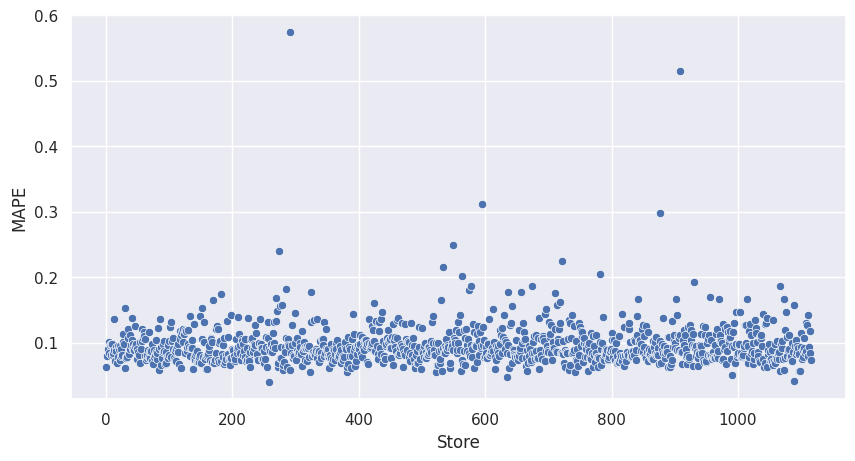

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot( x='Store', y='MAPE', data=df52 )

Pelo gráfico observamos que a maioria das lojas estão com um MAPE por volta de 10%.

#### Performance total

Vamos somar os valores das predições, melhor cenário e pior cenário para todas as lojas.

In [ ]:
df53 = df52[['Predictions', 'Worst_scenario', 'Best_scenario']].apply(
    lambda x:np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df53['Values'] = df53['Values'].map( 'R${:,.2f}'.format )
df53

,Scenario,Values
0,Predictions,"R$283,161,152.00"
1,Worst_scenario,"R$282,421,935.79"
2,Best_scenario,"R$283,900,417.46"


No melhor cenário o volume de vendas de todas as lojas será de 283 milhões, e no pior, 282 milhões

#### Calculando o resíduo das previsões

In [ ]:
df3['Error'] = df3['Sales'] - df3['Predictions']
df3['Error_rate'] = df3['Predictions'] / df3['Sales']

In [ ]:
df3.head()

,Store,Promo,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,Date,Sales,Predictions,Error,Error_rate
0,1,1,2,1,-0.170968,9,2008,0,31,2015,...,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,5263.0,5535.008789,-272.008789,1.051683
1,2,1,0,1,-0.283871,11,2007,1,13,2010,...,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,6064.0,6014.352539,49.647461,0.991813
2,3,1,0,1,1.903226,12,2006,1,14,2011,...,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,8314.0,9294.150391,-980.150391,1.117892
3,4,1,2,3,-0.275806,9,2009,0,31,2015,...,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,13995.0,11639.132812,2355.867188,0.831664
4,5,1,0,1,4.448387,4,2015,0,31,2015,...,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,4822.0,6632.675781,-1810.675781,1.375503


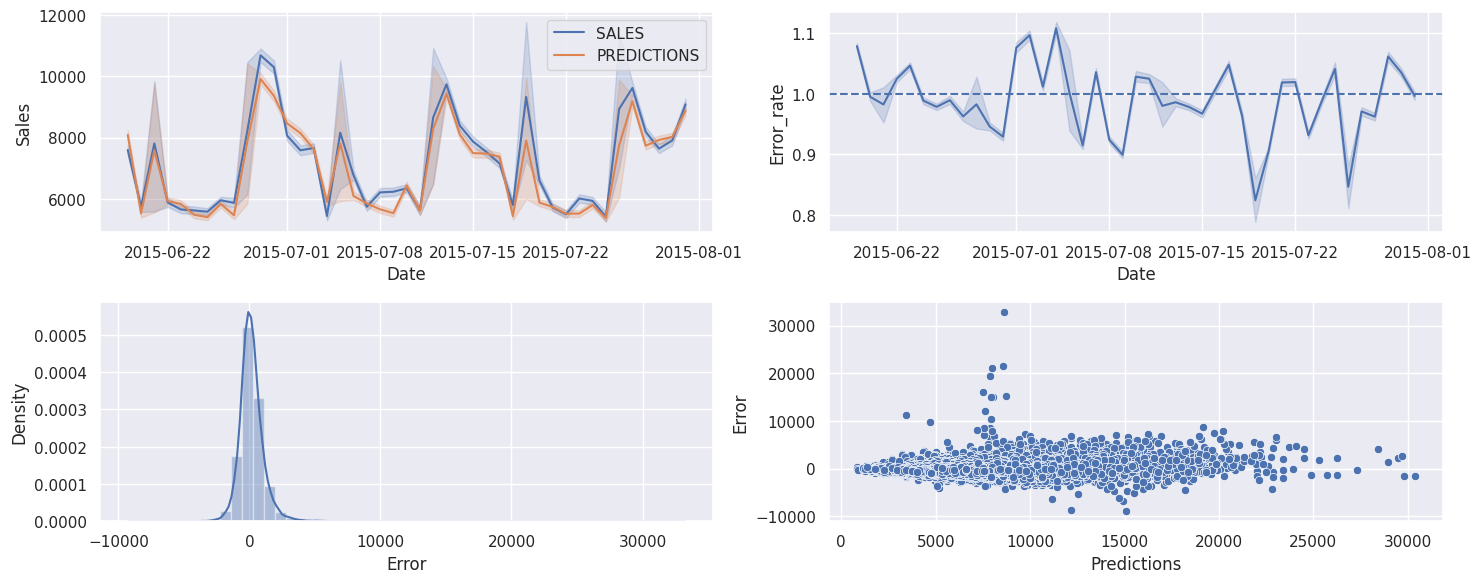

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot( 2, 2, 1 )
sns.lineplot( x='Date', y='Sales', data=df3, label='SALES' )
sns.lineplot( x='Date', y='Predictions', data=df3, label='PREDICTIONS' )
plt.subplot( 2, 2, 2 )
sns.lineplot( x='Date', y='Error_rate', data=df3 )
plt.axhline( 1, linestyle='--')
plt.subplot( 2, 2, 3 )
sns.distplot( df3['Error'] )
plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df3['Predictions'], y=df3['Error'] )
plt.tight_layout()

 - Observamos que as previsões do modelo foram bem próximas das vendas reais
 - A distribuição dos erros é aproximadamente normal
 - Por último, vemos que sempre que as previsões estão aproximadamente entre 8 e 10 mil o erro é maior, mas de maneira geral, os erros parecem estar dentro do que chamamos de tubo (que é um bom sinal)

In [ ]:
import pickle

In [ ]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( './model_rossmann.pkl', 'wb' ) )